# Tester: Nonlinear Langevin
## Double-welled overdamped Langevin (DWOL)

Here we take for out potential the function $$V(x) = 1/4(x^2-1)^2$$ and so the (overdamped, stochastic) Langenvin equation is $$dX_t = -V'(X_t)dt + \sigma dW_t = -X_t(X_t^2-1) + \sigma dW_t$$
We solve this numerically in various ways to get an approximate solution if to the equation. For instance we will often use Euler-Maruyama which soluction takes the form 
$$Y_{n+1} = Y_{n} + \Delta t\big(-Y_n(Y_n^2-1)\big) + \sigma \sqrt{\Delta t}v_n$$
where $Y_n \approx X_{\Delta t n}$ and $v_n \sim N(0,1)$ for all $n = 0,1,2,\dots$ are i.i.d.

The goal here is to reproduce the statisical and dynamical information (?). Of a realization of $Y = (Y_n;\;n=o,1,2,\dots)$ using a reduced model. We will compare the autocavariances as well as the pdf the $Y_n$. 

So, first we run the full model. To do this I use the function `DataGen_DWOL` found in th file `DataGen.jl` found in the current folder (`Examples\Nonlinear Langevin`).

In [1]:
using PyPlot
using Random

# Get software to generate model
include("../Nonlinear Langevin/DataGen.jl")

# Get model reduction software being tested
include("../../Tools/Model_Reduction_Dev.jl")

# Get tester tools
include("testertools.jl")

causal_test (generic function with 1 method)

In [2]:
# Model run Parameters
steps = 10^7 + 1
scheme = "FE"
t_start = 0
t_stop = 10^6
discard = 100000
sig_init = [1.5]
sigma = [.5]
V_prime = x -> -x.*(x.^2 .- 1)
SM1 = false
Obs_noise = false
d = 1
# e = randn(d,steps + discard)

dt = (t_stop - t_start)/(steps - 1)


# Get full model run
Random.seed!(2014)
X = DataGen_DWOL(
    steps;
    scheme, t_start, t_stop, discard, 
    sig_init , sigma, V_prime,
    SM1, Obs_noise, d
    )

1×10000001 Array{Float64,2}:
 1.18133  1.36549  1.32708  1.20525  …  1.47027  1.5167  1.23786  1.29148

In [ ]:
# plot(X[1,1:10:end])

In [44]:
# Put in Psi functions
Psi(x) = [x; x.^3]

# Model reduction Parameters
M_out = 100
n = 3
p = 200
par = 500
ty = "bin"
xspec_est = "DM"
rl = false
Preds = true
PI = false
rtol = 1e-6

nfft = 2^16

@time h_pack_dm = get_wf(X, Psi;
    M_out, n, p, par, ty, nfft, rl, xspec_est, Preds, PI, rtol);

Number of CKMS iterations: 402
errK errR : 3.814358539405026e-11 2.970506035330059e-12
 28.161921 seconds (33.02 M allocations: 14.391 GiB, 5.36% gc time)


In [45]:
# Put in Psi functions
Psi(x) = [x; x.^3]

# Model reduction Parameters
n = 3
p = 200
ty = "bin"

xspec_est = "SP"

nfft = 0

@time h_pack_sp = get_wf(X, Psi;
    M_out, n, p, par, ty, nfft, rl, xspec_est, Preds, PI, rtol);

Number of CKMS iterations: 402
errK errR : 3.814358539405026e-11 2.970506035330059e-12
 68.053117 seconds (590.16 M allocations: 44.392 GiB, 10.11% gc time)


In [46]:
h_wf_dm                              = h_pack_dm[1][1]
z_spect_pred_minus_num_fft_dm        = h_pack_dm[1][4]
z_spect_pred_plus_num_fft_dm         = h_pack_dm[1][5]
S_sigpred_overS_plus_fft_num_dm      = h_pack_dm[1][6]
S_sigpred_overS_plus_plus_num_fft_dm = h_pack_dm[1][7]
H_num_dm                             = h_pack_dm[1][8];

In [47]:
h_wf_sp                              = h_pack_sp[1][1]
z_spect_pred_minus_num_fft_sp        = h_pack_sp[1][4]
z_spect_pred_plus_num_fft_sp         = h_pack_sp[1][5]
S_sigpred_overS_plus_fft_num_sp      = h_pack_sp[1][6]
S_sigpred_overS_plus_plus_num_fft_sp = h_pack_sp[1][7]
H_num_sp                             = h_pack_sp[1][8];

In [48]:
nfft_sp = size(H_num_sp,3)
nfft_dm = size(H_num_dm,3)
T_sp = 2π*(0:nfft_sp-1)/nfft_sp
T_dm = 2π*(0:nfft_dm-1)/nfft_dm

0.0:9.587379924285257e-5:6.2830894333803435

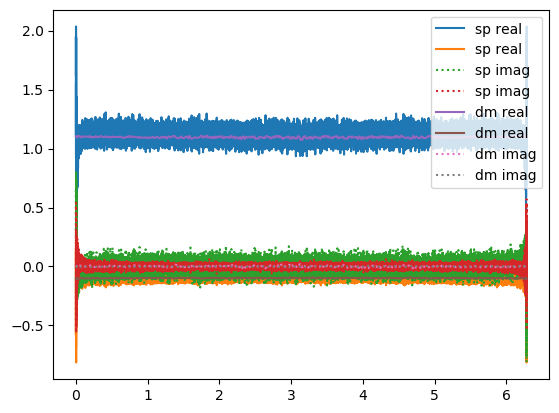

sys:1: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


PyObject <matplotlib.legend.Legend object at 0x000000005CF72F88>

In [49]:
plot(T_sp[1:100:end],real(H_num_sp[1,:,1:100:end]'),label = "sp real")
plot(T_sp[1:100:end],imag(H_num_sp[1,:,1:100:end]'),":",label = "sp imag")
plot(T_dm,real(H_num_dm[1,:,:]'),label = "dm real")
plot(T_dm,imag(H_num_dm[1,:,:]'),":",label = "dm imag")
legend()

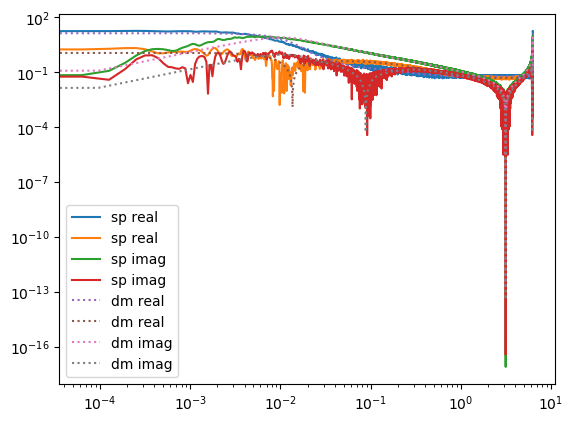

sys:1: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


PyObject <matplotlib.legend.Legend object at 0x000000005ED11B88>

In [56]:
loglog(T_sp[1:100:end],abs.(real(S_sigpred_overS_plus_plus_num_fft_sp[1,:,1:100:end]')),label = "sp real")
loglog(T_sp[1:100:end],abs.(imag(S_sigpred_overS_plus_plus_num_fft_sp[1,:,1:100:end]')),label = "sp imag")
loglog(T_dm,abs.(real(S_sigpred_overS_plus_plus_num_fft_dm[1,:,:]')),":",label = "dm real")
loglog(T_dm,abs.(imag(S_sigpred_overS_plus_plus_num_fft_dm[1,:,:]')),":",label = "dm imag")
legend()

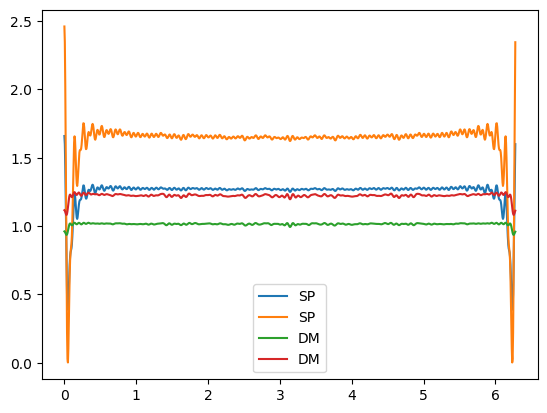

C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


PyObject <matplotlib.legend.Legend object at 0x000000000815FD88>

In [19]:
h_wf_sp_pad = cat(h_wf_sp,zeros(1,2,924),dims = 3)
H_wf_sp = fft(h_wf_sp_pad)

theta = 2π*(0:1023)/1024
plot(theta,H_wf_sp[1,:,:]',label = "SP")

h_wf_dm_pad = cat(h_wf_dm,zeros(1,2,924),dims = 3)
H_wf_dm = fft(h_wf_dm_pad)

theta = 2π*(0:1023)/1024
plot(theta,H_wf_dm[1,:,:]',label = "DM")
legend()

In [9]:
# Put in Psi functions
Psi(x) = [x; x.^3]

# Model reduction Parameters
M_out = 100
n = 3
p = 200
par = 55
ty = "bin"
xspec_est = "DM"
rl = true
Preds = true
PI = false
rtol = 1e-6

nfft = 2^10

@time h_wf_dm, pred, matlog1, matlog2 = get_wf(X, Psi;
    M_out, n, p, par, ty, nfft, rl, xspec_est, Preds, PI, rtol);

println(minimum(matlog2))
h_wf_dm

Number of CKMS iterations: 151
errK errR : 5.994089067776333e-11 2.2696159655477494e-13
 25.386870 seconds (30.17 M allocations: 14.102 GiB, 8.05% gc time)
0.04161549536962241


1×2×100 Array{Float64,3}:
[:, :, 1] =
 1.09665  -0.0985019

[:, :, 2] =
 0.00224742  -0.000937646

[:, :, 3] =
 0.000772752  -0.000520298

...

[:, :, 98] =
 1.01117e-8  -3.35683e-9

[:, :, 99] =
 4.04101e-8  -1.38527e-8

[:, :, 100] =
 8.88389e-8  -2.88579e-8

In [10]:
# Put in Psi functions
Psi(x) = [x; x.^3]

# Model reduction Parameters
M_out = 100
n = 3
p = 200
par = 55
ty = "bin"
xspec_est = "SP"
rl = true
Preds = true
PI = false
rtol = 1e-6

nfft = 2^16

@time h_wf_dm, pred, matlog1, matlog2 = get_wf(X, Psi;
    M_out, n, p, par, ty, nfft, rl, xspec_est, Preds, PI, rtol);

println(minimum(matlog2))
h_wf_dm

Number of CKMS iterations: 151
errK errR : 5.994089067776333e-11 2.2696159655477494e-13
 19.408781 seconds (35.54 M allocations: 11.477 GiB, 8.99% gc time)
0.04161549536962241


1×2×100 Array{Float64,3}:
[:, :, 1] =
 1.65426  -0.243878

[:, :, 2] =
 -0.16117  0.0355848

[:, :, 3] =
 -0.146302  0.0381149

...

[:, :, 98] =
 0.000981219  0.000187274

[:, :, 99] =
 0.0102025  -0.00186804

[:, :, 100] =
 0.00650652  -0.00101233

## Analyze Wiener Filter

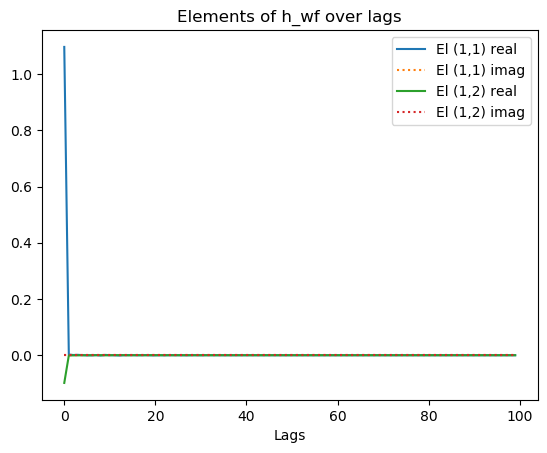

PyObject Text(0.5, 1, 'Elements of h_wf over lags')

In [9]:
plot_WF(h_wf, rl = false)

## Analyze One step prediction error

In [10]:
X_hat = one_step_pred(X_sig, h_wf, pred)

1×10000000 Array{Complex{Float64},2}:
 1.36549+0.0im  1.32708+0.0im  1.20525+0.0im  …  1.32053+0.0im  1.17089+0.0im

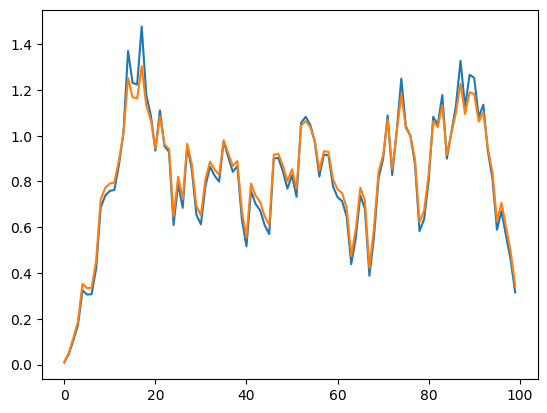

C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000130E1C8>
 PyObject <matplotlib.lines.Line2D object at 0x000000000119A648>

In [11]:
wind = (1:100) .+ 2400
plot([X_sig[1,wind] X_hat[1,wind.+1]])

In [12]:
X_err = X_sig - X_hat

1×10000000 Array{Complex{Float64},2}:
 0.0-0.0im  0.0-0.0im  0.0-0.0im  …  -0.0826704-0.0im  0.12059-0.0im

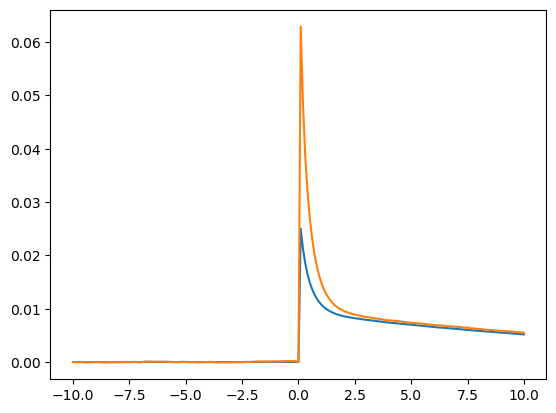

C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001204648>
 PyObject <matplotlib.lines.Line2D object at 0x000000000120FA08>

In [13]:
lags = -100:100
C1 = my_crosscov(pred[1,:],X_err[:],lags);
C2 = my_crosscov(pred[2,:],X_err[:],lags);

plot(dt*lags,[C1 C2])

## Analyze Reduced Model Run

In [14]:
X_rm = redmodrun(X, h_wf, Psi)


reduced model blewup at step 4559


1×10000001 Array{Complex{Float64},2}:
 1.18133+0.0im  1.36549+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im

# Trick (model mismatch)

In [23]:
# Put in Psi functions
Psi_cos(x) = [x; cos.(x)]
@time h_wf_cos, pred = get_wf(X, Psi_cos;
    M_out, n, p, par, ty, nfft, rl, Preds, PI, rtol);

Psi_sin(x) = [x; sin.(x)]
@time h_wf_sin, pred = get_wf(X, Psi_sin;
    M_out, n, p, par, ty, nfft, rl, Preds, PI, rtol);

Number of CKMS iterations: 142
errK errR : 3.033284092991424e-11 7.332473234776882e-14
 25.840413 seconds (30.39 M allocations: 14.107 GiB, 4.28% gc time)
Number of CKMS iterations: 134
errK errR : 2.8067871466590652e-11 9.67667683643104e-14
 25.473736 seconds (30.45 M allocations: 14.109 GiB, 3.77% gc time)


In [37]:
Psi_exp(x) = [x; exp.(x); exp.(-x)]
@time h_wf_exp, pred = get_wf(X, Psi_exp;
    M_out, n, p, par, ty, nfft, rl, Preds, PI, rtol);

Number of CKMS iterations: 152
errK errR : 2.3815525417790077e-11 7.732402895672146e-14
 50.552967 seconds (50.17 M allocations: 27.067 GiB, 3.58% gc time)


In [47]:
Psi_expi(x) = [x; exp.(im*x); exp.(-im*x)]
@time h_wf_expi, pred = get_wf(X, Psi_expi;
    M_out, n, p, par, ty, nfft, rl = false, Preds, PI, rtol);

Number of CKMS iterations: 153
errK errR : 9.575804069724448e-11 4.1964514466288714e-12
 55.058787 seconds (60.20 M allocations: 28.111 GiB, 3.75% gc time)


In [48]:
fun(x) = (1+dt)*x-dt*x^3
fun_c(x) = h_wf[:,:,1]*Psi(x)
fun_cos(x) = h_wf_cos[:,:,1]*Psi_cos(x)
fun_sin(x) = h_wf_sin[:,:,1]*Psi_sin(x)
fun_exp(x) = h_wf_exp[:,:,1]*Psi_exp(x)
fun_expi(x) = h_wf_expi[:,:,1]*Psi_expi(x)

fun_expi (generic function with 1 method)

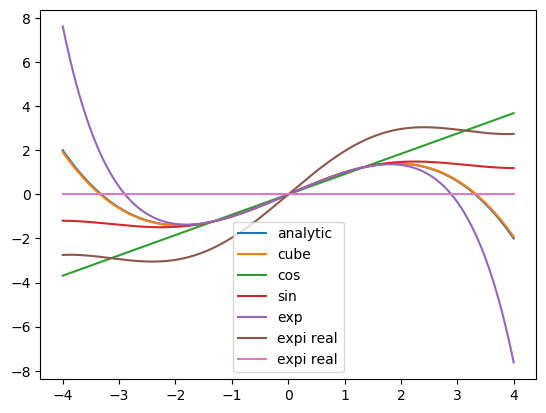

[1.0966512958578813 -0.09850189214264782]
[0.9215232475279427 5.588305824438427e-5]
[0.427088517157567 0.6803448354214279]
[1.600375180633439 -0.25698610527635224 0.2568615358914853]
Complex{Float64}[0.9208636152121881 + 3.7372842091291495e-16im 3.231016191807467e-5 - 0.619949748187647im 3.231016191671169e-5 + 0.619949748187649im]


PyObject <matplotlib.legend.Legend object at 0x000000004CFA0C48>

In [49]:
xx = -4:0.01:4
plot(xx,fun.(xx),label = "analytic")
plot(xx,fun_c.(xx),label = "cube")
plot(xx,fun_cos.(xx),label = "cos")
plot(xx,fun_sin.(xx),label = "sin")
plot(xx,fun_exp.(xx),label = "exp")
plot(xx,real(fun_expi.(xx)),label = "expi real")
plot(xx,imag(fun_expi.(xx)),label = "expi real")
println(h_wf[:,:,1])
println(h_wf_cos[:,:,1])
println(h_wf_sin[:,:,1])
println(h_wf_exp[:,:,1])
println(h_wf_expi[:,:,1])
legend()